In [1]:
import sys
sys.path.append('../python_packages_static/')
import pandas as pd
import pyemu
import flopy as fp
import matplotlib.pyplot as plt
import numpy as np
import os, glob, shutil
import geopandas as gp
import datetime as dt
import flopy as fp
from shapely.geometry import Point
from matplotlib.backends.backend_pdf import PdfPages

# Postprocessing of iES runs. There are two key decisions to make. Which iteration is the best (subjective) tradeoff between fit and variance in the ensemble and, given a chosen iteration, what is an appropriate cutoff for rejection sampling. These decisions lead to visualization of the observation fits and generation of the ensemble to be used with MODPATH for the source water area delineation.

### NOTE: Make sure  `run_ensemble` is set appropriately - If `run_ensemble` is set to `True`, local runs are performed. If `run_ensemble` set to `False`results from the journal article are used. 

In [2]:
run_ensemble=False

In [3]:
if run_ensemble==True:
    rundir = '../run_data'                # directory in which runs took place
else:
    rundir = '../output/parallel'
pstroot = 'never_ies_0.noise_lt_obs'  # PST file root for iES
outfolder = '{}/postproc/'.format(rundir)  # write out output files to this location
obs_data = '../processed_data/'
drop_pdc = False

### Visualize the Phi of the whole ensemble as it evolves over the iterations

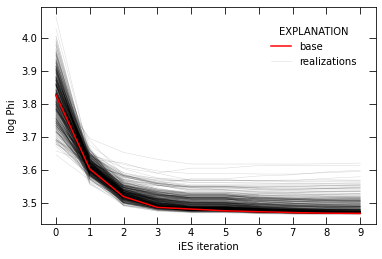

In [4]:
phi = pd.read_csv(os.path.join(rundir,"{}.phi.actual.csv".format(pstroot)),index_col=0)
plt.figure(figsize=(6,4))
ax = phi['base'].apply(np.log10).plot(legend=False, lw=1.5, color='r', label='base')
phi.iloc[:,6:7].apply(np.log10).plot(legend=False,lw=0.5,color='k',alpha=0.15,label='realizations', ax = ax)
plt.legend(['base','realizations'])
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,alpha=0.15,color='k', ax = ax)
phi['base'].apply(np.log10).plot(legend=False, lw=1.5, color='r', ax=ax)
plt.ylabel('log Phi')
plt.xlabel('iES iteration')
plt.xticks(ticks=np.arange(10))
ax.axes.tick_params(length=7, direction='in', right=True, top=True)
plt.legend(['base','realizations'], title='EXPLANATION', frameon=False, bbox_to_anchor =(0.97, 0.95))


In [5]:
phi

,total_runs,mean,standard_deviation,min,max,0,1,2,3,4,...,490,491,492,493,494,495,496,497,498,base
iteration,,,,,,,,,,,,,,,,,,,,,
0,500,6795.30,1140.490,4426.38,11589.20,6932.28,8591.66,9484.93,6204.96,5153.65,...,8214.17,8199.26,5381.08,6395.55,6098.38,8375.92,9096.47,5798.44,7211.02,6710.94
1,1143,4100.26,210.244,3592.58,4957.09,3910.25,4259.87,4301.77,4075.78,4413.70,...,4495.08,3607.22,3894.55,3791.85,3888.53,3908.82,4213.20,4151.77,3873.70,4008.38
2,1780,3399.48,176.986,3094.35,4498.10,3153.76,3588.78,3194.49,3324.72,3648.75,...,3901.50,3240.58,3271.71,3316.42,3334.90,3264.30,3294.27,3471.25,3178.23,3304.48
3,2410,3206.45,173.336,2983.44,4284.15,3031.73,3429.89,3140.27,3186.34,3428.76,...,3685.40,3070.19,3169.03,NaN,3069.70,3059.40,3056.28,3264.86,3071.24,3064.73
4,3033,3131.77,166.123,2949.33,4146.75,2971.02,3345.52,3163.38,3152.54,3283.10,...,3558.23,3018.40,3095.30,NaN,2999.00,3012.51,3000.66,3176.84,3008.23,3028.94
5,3193,3130.80,165.983,2949.33,4146.75,2971.02,3345.52,3163.38,3152.54,3283.10,...,3558.23,3018.40,3095.30,NaN,2999.00,3012.51,3000.66,3176.84,3008.23,2992.65
6,3815,3091.13,167.317,2928.34,4149.59,2947.47,3267.32,3153.28,3136.60,3225.26,...,3507.80,2992.70,3044.94,NaN,2998.25,2993.07,2983.30,3118.61,2988.16,2974.26
7,4420,3070.07,169.696,2923.22,4144.80,2941.24,3232.03,3161.05,3134.12,3205.97,...,NaN,NaN,3033.30,NaN,NaN,NaN,NaN,NaN,NaN,2956.28
8,5025,3058.01,175.449,2920.96,4155.12,2937.96,3214.41,3133.98,3120.76,3201.46,...,NaN,NaN,3016.92,NaN,NaN,NaN,NaN,NaN,NaN,2943.16


In [6]:
pst = pyemu.Pst('{0}/{1}.pst'.format(rundir, pstroot))

### a `bounds_report` helps visualize, for the base realization, how many parameters were at their bounds. This can help guide the decision of whether iterations are overfit or not.

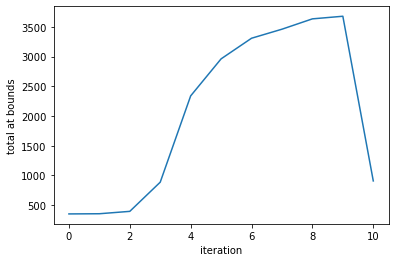

In [7]:
df = pst.bounds_report()
df_tot =  df[[i for i in df.columns if 'either' in i]].loc['total'].copy()
df_tot.index = [int(i.split('_')[-1]) for i in df_tot.index]
df_tot.plot()
plt.xlabel('iteration')
plt.ylabel('total at bounds')
plt.grid()
plt.grid()

### we are choosing iteration 4 as best

In [8]:
best_iter = 4
# re-read in the PST file but now with the residuals corresponding with the best iteration
pst = pyemu.Pst('{0}/{1}.pst'.format(rundir, pstroot), 
                resfile=os.path.join(rundir,'{}.{}.base.rei'.format(pstroot,best_iter)))
obs=pst.observation_data

### we can make a quick 1to1 plot of the base ensemble member

In [9]:
pst.plot(kind='1to1', filename='../figures/{0}.{1}_iter_{2}.pdf'.format( pstroot, '.base.1to1', best_iter))


### here we decide whether or not we will visualize results which were in prior data conflict (PDC)

In [10]:
if drop_pdc is True:
    # read in the PDC list of values
    pdc = pd.read_csv(os.path.join(rundir,'{}.pdc.csv'.format(pstroot)))
    pdc.name = pdc.name.apply(lambda x: x.lower())
    # zero weight all the PDC values
    obs.loc[pdc.name.values, 'weight'] = 0

## plot residuals only for nonzero weight for the base realization which is read in automatically when `pyemu` reads in the pst control file

In [11]:
assert(np.unique(pst.res.index == obs.index))==np.array(True)

In [12]:
tmpres = pst.res.copy()
tmpres.weight = obs.weight


In [13]:
tmpres = tmpres.loc[pst.res.weight>0]
print(len(tmpres))
tmpres.head()

525


,name,group,measured,modelled,residual,weight
name,,,,,,
q_1436500,q_1436500,flux,116217.231560,101680.000000,14537.231560,0.001014
q_1366650,q_1366650,flux,124046.273310,128230.000000,-4183.726690,0.002852
h_414525074360601,h_414525074360601,head,357.182016,359.093466,-1.911451,0.091297
h_o10577,h_o10577,head,203.903379,195.797668,8.105710,0.091297
h_o10942,h_o10942,head,150.660417,155.416464,-4.756047,0.091297


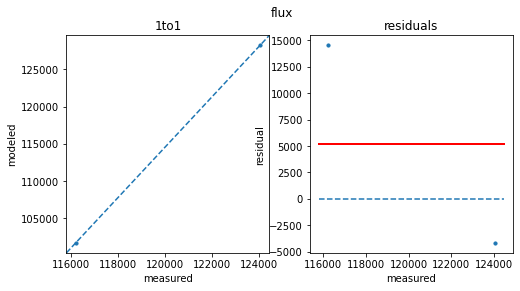

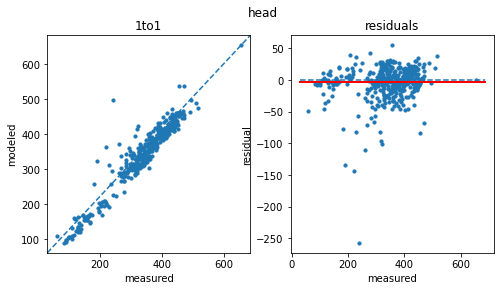

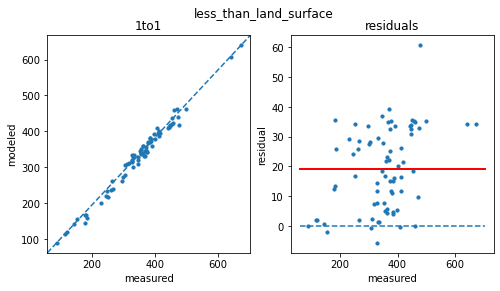

In [14]:
for cn,cg in tmpres.groupby('group'):
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].plot([0, 1], [0, 1],'--',transform=ax[0].transAxes)
    ax[0].scatter(cg.measured,cg.modelled, s=10)
    ax[0].set_xlabel('measured')
    ax[0].set_ylabel('modeled')
    ax[0].set_title('1to1')
    ax[1].scatter(cg.measured, cg.residual, s=10)
    xlim = ax[1].get_xlim()
    ax[1].plot(xlim, [0,0], '--')
    ax[1].plot(xlim, [cg.residual.mean(),cg.residual.mean()], 'r-', lw=2)
    ax[1].set_title('residuals')
    plt.suptitle(cn)
    ax[1].set_xlabel('measured')
    ax[1].set_ylabel('residual')

# Rejection Sampling. We can look at the PHI histogram for the best iteration and assign a cutoff of `phi_too_high` which delineates where rejection takes place

In [15]:
phivec = phi.loc[best_iter][5:].copy()

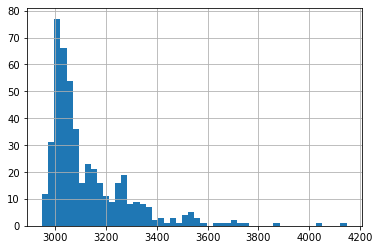

In [16]:
phivec.hist(bins=50)

In [17]:
phi_too_high= 3200 

## the next couple cells seem extra involved, but they are meant to make fancy figures for the journal; article showing PHI evolution over iterations and the rejection sampling all together.

In [18]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

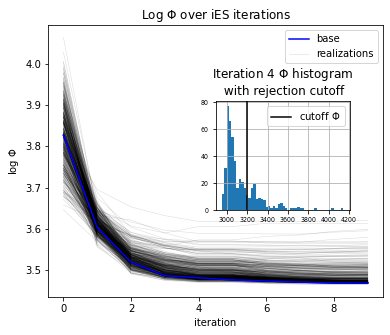

In [19]:
fig = plt.figure(figsize=(6,5))
ax = phi['base'].apply(np.log10).plot(legend=False, lw=1.5, color='b', label='base')
phi.iloc[:,6:7].apply(np.log10).plot(legend=False,lw=0.5,color='k',alpha=0.15,label='realizations', ax = ax)
plt.legend(['base','realizations'])
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,alpha=0.15,color='k', ax = ax)
phi['base'].apply(np.log10).plot(legend=False, lw=1.5, color='b', ax=ax)
plt.ylabel('log $\Phi$')

ax1 = add_subplot_axes(ax, [0.5,.32,.4,0.4])
ax1.axvline(phi_too_high, color='k', label='cutoff $\Phi$')
ax1.legend()
phivec = phi.loc[best_iter][5:].copy()
phivec.hist(bins=50, ax=ax1)
ax.set_title('Log $\Phi$ over iES iterations')
ax1.set_title('Iteration 4 $\Phi$ histogram\n with rejection cutoff') 

plt.savefig('../figures/phi_and_rejection.pdf')

Number of reals before rejection sampling: 500
Number of reals after rejection sampling: 358


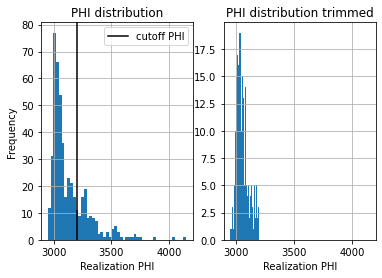

In [20]:
phivec = phi.loc[best_iter][5:].copy()
fig, ax = plt.subplots(1,2, figsize=(6,4))
phivec.hist(bins=50, ax=ax[0])
ax[0].axvline(phi_too_high, color='k', label='cutoff PHI')
ax[0].legend()
ax[0].set_ylabel('Frequency')
print('Number of reals before rejection sampling: {}'.format(len(phivec)))
phivec = phivec[phivec<phi_too_high]
print('Number of reals after rejection sampling: {}'.format(len(phivec)))
phivec.hist(bins=50, ax=ax[1])
ax[1].set_xlim(ax[0].get_xlim())
ax[0].set_xlabel('Realization PHI')
ax[1].set_xlabel('Realization PHI')
ax[0].set_title('PHI distribution')
ax[1].set_title('PHI distribution trimmed')

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc='best')


plt.savefig('../figures/Figure20_rejectionsampling.pdf')

### now we need to make a `reals_to_keep` vector that keeps track of the ensemble members that made it through rejection sampling

In [21]:
reals_to_keep = phivec.index.values

### in early stages of the project, there were cases where some model results with reasonable PHI had poor mass balance, so we rejected them as well. Now that is not a problem, but the logic is shown here nonetheless.

In [22]:
# truncate the ensemble to only reals_to_keep (based on phi)
ens = pd.read_csv(os.path.join(rundir,'{}.0.obs.csv'.format(pstroot)), index_col=0)

ens = ens.loc[reals_to_keep]
# set percent_discrepancy to absolute value because we don't care about the sign
ens.perc_disc = ens.perc_disc.apply(lambda x: np.abs(x))

In [23]:
# further truncate to eliminate bad mass balance runs 
ens = ens.loc[ens.perc_disc<0.01]
ens

,q_1436500,q_1366650,h_414525074360601,h_o10577,h_o10942,h_o11068,h_o5124,h_o6269,h_o7421,h_o8073,...,land_surf_obs_500_400,land_surf_obs_500_450,land_surf_obs_500_500,land_surf_obs_550_400,land_surf_obs_550_450,land_surf_obs_550_500,land_surf_obs_600_350,land_surf_obs_600_400,land_surf_obs_600_450,land_surf_obs_650_450
real_name,,,,,,,,,,,,,,,,,,,,,
0,95226,145490,358.418,201.242,155.240,111.311,341.365,480.390,148.231,200.436,...,400.988,216.586,167.168,323.550,166.667,330.867,411.284,273.919,154.860,241.344
2,99750,152280,359.100,200.740,155.372,113.440,340.930,477.603,147.165,199.901,...,398.971,216.578,167.499,322.784,166.855,330.831,410.060,273.211,155.129,240.580
3,96978,143760,359.337,192.648,155.380,110.553,338.615,473.096,142.882,198.017,...,392.311,216.469,165.550,317.337,165.981,330.221,408.224,272.665,154.702,237.611
5,99275,142330,359.353,186.681,156.222,112.129,337.452,471.582,141.081,197.511,...,389.110,216.450,165.018,316.973,166.673,330.106,407.479,272.530,155.205,236.147
6,96987,145610,358.872,197.691,155.109,113.372,340.094,474.676,144.894,198.801,...,395.009,216.504,165.428,320.125,166.604,330.417,408.972,272.830,155.001,238.783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,99408,149830,359.061,198.004,155.049,110.622,339.903,475.998,145.150,198.883,...,395.904,216.504,166.770,320.876,167.171,330.418,409.571,272.976,155.321,238.850
496,98395,151420,359.007,196.895,155.669,111.953,340.194,474.981,145.105,198.835,...,394.988,216.518,166.276,320.977,164.654,330.399,409.109,272.727,155.374,238.112
497,97512,142470,359.103,199.085,155.799,114.105,340.798,477.101,146.006,199.225,...,397.101,216.518,167.316,321.121,168.643,330.643,410.304,273.340,154.814,240.259


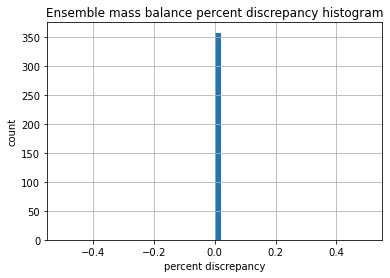

In [24]:
ens.perc_disc.hist(bins=50)
plt.title('Ensemble mass balance percent discrepancy histogram')
plt.ylabel('count')
plt.xlabel('percent discrepancy')
plt.show()

In [25]:
# get rid of zero-weighted values dropped in the PDC
ens = ens[tmpres.index]

In [26]:
# reset keepreals based now both on phi and mass balance
reals_to_keep = ens.index.values

In [27]:
phivec = phivec.loc[reals_to_keep]

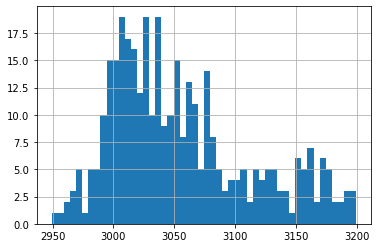

In [28]:
phivec.hist(bins=50)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

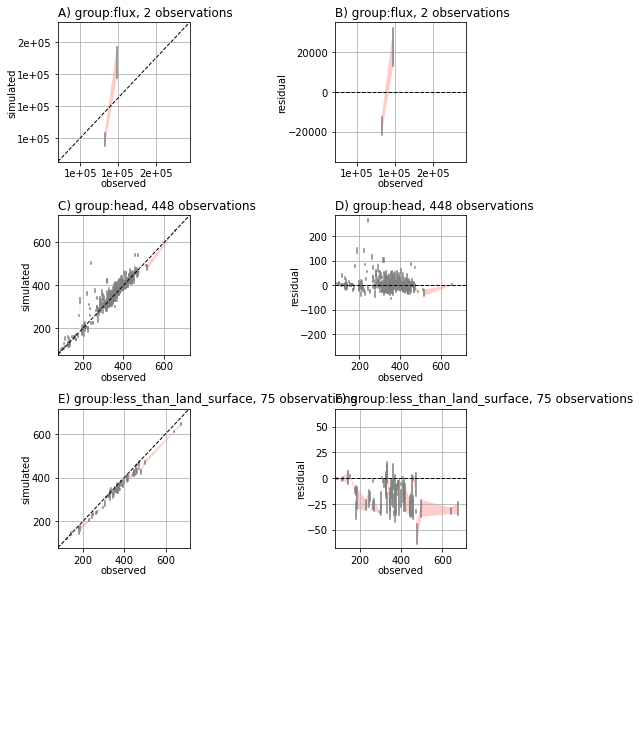

In [29]:
base_ens = pd.read_csv(os.path.join(rundir,'{}.0.obs.csv'.format(pstroot)), index_col=0)
base_ens = base_ens.loc[reals_to_keep]
base_ens = base_ens[tmpres.index]
pyemu.plot_utils.ensemble_res_1to1(ens, pst, base_ensemble=base_ens)

In [30]:
pdc = pd.read_csv(os.path.join(rundir,'{}.pdc.csv'.format(pstroot)))
pdc.name = pdc.name.apply(lambda x: x.lower())
pdc.set_index('name', inplace=True, drop=True)
pdc

,obs_mean,obs_std,obs_min,obs_max,obs_stat_min,obs_stat_max,sim_mean,sim_std,sim_min,sim_max,sim_stat_min,sim_stat_max,distance
name,,,,,,,,,,,,,
h_o11068,59.2867,1.68222,55.2937,63.6483,54.2401,64.3334,111.871,1.386060,108.654,115.526,107.713,116.029,43.37950
h_o6269,515.0610,1.68734,510.0180,520.3240,509.9990,520.1230,478.778,5.794500,470.508,497.301,461.395,496.162,13.83750
h_o8073,223.7930,1.69574,219.4500,228.8600,218.7060,228.8800,199.796,1.816890,197.468,206.181,194.345,205.247,13.45930
h_o8419,340.2670,1.69836,335.7580,344.5660,335.1720,345.3620,365.742,3.602250,356.784,374.919,354.935,376.549,9.57276
h_sv1014,334.8370,1.63794,330.5990,338.8550,329.9230,339.7510,362.484,3.978800,352.329,371.270,350.547,374.420,10.79670
...,...,...,...,...,...,...,...,...,...,...,...,...,...
h_u8543,228.8480,1.68178,224.7100,234.5490,223.8020,233.8930,312.456,0.663916,310.877,314.502,310.465,314.448,76.57160
h_u8544,318.1270,1.74950,313.7050,322.8760,312.8780,323.3750,416.522,3.646160,410.972,427.174,405.583,427.460,82.20820
h_u8851,282.7960,1.74841,278.1590,287.7150,277.5510,288.0410,343.084,0.796479,340.123,345.165,340.694,345.473,52.65330


## plot without PDC 

In [31]:
drop_pdc = [i for i in pdc.index if not i.startswith('q_')] # make sure we still plot streamflow even if in PDC. 
        # should not be the case

In [32]:
ens = ens[[i for i in ens.columns if i not in drop_pdc]]
base_ens = base_ens[[i for i in ens.columns if i not in drop_pdc]]

In [33]:
tmpres = tmpres.loc[[i for i in ens.columns if i not in drop_pdc]]

In [34]:
obs_ens = pd.read_csv(os.path.join(rundir,'{}.obs+noise.csv'.format(pstroot)), index_col=0)
obs_ens = obs_ens.loc[reals_to_keep]
obs_ens


,q_1436500,q_1366650,h_414525074360601,h_o10577,h_o10942,h_o11068,h_o5124,h_o6269,h_o7421,h_o8073,...,land_surf_obs_500_400,land_surf_obs_500_450,land_surf_obs_500_500,land_surf_obs_550_400,land_surf_obs_550_450,land_surf_obs_550_500,land_surf_obs_600_350,land_surf_obs_600_400,land_surf_obs_600_450,land_surf_obs_650_450
real_name,,,,,,,,,,,,,,,,,,,,,
0,115063.0,116048,359.010,206.377,147.689,59.7465,336.135,515.684,133.969,224.177,...,414.008,251.867,180.468,344.767,177.270,365.741,441.054,303.121,149.007,264.971
2,94842.6,118875,356.667,206.945,150.239,59.0454,334.093,515.184,133.939,225.320,...,411.356,253.096,180.582,346.693,179.995,358.788,437.780,296.722,158.531,269.488
3,95428.8,122800,355.139,200.785,149.688,59.2477,336.063,514.745,134.607,221.986,...,413.112,247.403,183.554,351.567,180.402,362.718,440.972,296.822,152.305,264.640
5,115373.0,119680,356.441,205.415,151.613,58.9551,333.739,515.387,131.642,223.905,...,408.735,248.934,189.354,343.817,178.951,370.904,448.797,300.280,146.142,270.966
6,106595.0,122428,357.450,201.266,151.098,57.9052,336.279,519.203,130.438,226.368,...,406.396,248.148,178.361,347.736,177.335,363.682,443.576,295.074,154.028,268.823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,117652.0,118034,357.237,202.917,149.576,58.6343,335.078,516.741,131.696,225.813,...,410.939,252.502,174.527,347.724,174.053,361.957,445.038,295.820,151.566,267.327
496,116041.0,120618,355.768,202.719,150.294,62.3323,336.334,515.270,134.282,223.242,...,410.634,247.179,183.254,347.361,178.818,371.752,442.168,304.840,149.909,268.194
497,118641.0,128344,355.812,203.958,150.587,58.9540,335.673,514.062,133.511,223.168,...,417.721,248.734,173.319,345.846,180.029,364.644,443.933,301.395,151.243,268.774


## In this case, with sampling of observation noise, looking for overlap of distributions

In [35]:
plot_pdf = False

In [36]:
if plot_pdf==True:
    with PdfPages('../figures/{}_trimmed_pdc_obs_hist_plots.pdf'.format(pstroot)) as outpdf:
        for cob in tmpres.index.values:
            plt.figure()

            obs_ens[cob].hist(bins=50, color='orange', edgecolor='none', alpha=.7,label='observed')
            ens[cob].hist(bins=50, edgecolor='none', label='modelled')
            plt.axvline(obs_ens[cob].mean(), mfc='k', alpha=.5,label='obs mean')
            plt.axvline(obs_ens[cob].mean()+obs_ens[cob].std(), mfc='k', ls=':', alpha=.5, label='obs + 1$\sigma$')
            plt.axvline(obs_ens[cob].mean()-obs_ens[cob].std(), mfc='k', ls=':', alpha=.5, label='obs - 1$\sigma$')


            plt.title(cob)
            plt.legend()
            outpdf.savefig()
            plt.close('all')


# After all the visualization, we save out the paremeter ensemble to supply to MODPATH for the final source water area delineation

In [37]:
par_ens = pd.read_csv(os.path.join(rundir,'{0}.{1}.par.csv'.format(pstroot, best_iter)), index_col=0)
par_ens.index = [str(i) for i in par_ens.index]
par_ens = par_ens.loc[reals_to_keep]
par_ens.to_csv('../run_data/modpath_par_ens.csv')

C:\ProgramData\Anaconda3\envs\NDST\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# And finally, we can save out the base realization as a representative single model serving as an optimal set of parameters and outputs

### select the base realization from the parameter ensemble corresponding to the best iteration


In [38]:
base_pars = par_ens.loc['base']

#### read in the `pst` control file and assign the base parameters to the `parval1` values (e.g. starting parameters)


In [39]:
pst = pyemu.Pst('{0}/{1}.pst'.format(rundir, pstroot), 
                resfile=os.path.join(rundir,'{}.{}.base.rei'.format(pstroot,best_iter)))
pst.parameter_data.loc[:,'parval1'] = base_pars

#### make a copy of `run_data` to contain the representative ensemble run and call it
#### `representative_optimal_ensemble_run`

In [40]:
if os.path.exists('../representative_optimal_ensemble_run'):
    shutil.rmtree('../representative_optimal_ensemble_run')
shutil.copytree('../run_data','../representative_optimal_ensemble_run' )

'../representative_optimal_ensemble_run'

#### then we can write out the `pst` control file with the optimal base set of parameters

In [41]:
pst.control_data.noptmax=0
pst.write('../representative_optimal_ensemble_run/optimal_base_run.pst')

noptmax:0, npar_adj:4911, nnz_obs:525


In [42]:
pyemu.os_utils.run('pestpp-ies optimal_base_run.pst',
                  cwd = '../representative_optimal_ensemble_run',
                  verbose=True)

run():pestpp-ies.exe optimal_base_run.pst


## The following lines are to arrange output for the USGS archive. This is optional but included to demonstrate the ability to automate generating the optimal model, moving it, and parsing output files to the output directory. Setting `update_archive = True` will activate this

In [43]:
update_archive = True
if update_archive == True:
    # read in the optimal modflow files
    opt_model = fp.mf6.MFSimulation.load(sim_ws = '../representative_optimal_ensemble_run/')
    # set a new output path to write them to
    opt_model.set_sim_path('../neversink_mf6_optimal')
    # write the simulation
    opt_model.write_simulation()
    # run the simulation
    try:
        pyemu.os_utils.run('mf6',
                      cwd = '../neversink_mf6_optimal/',
                      verbose=True)
    except:
        # if modflow is not in system path, copy it over from representative_optimal_ensemble_run
        shutil.copy2('../representative_optimal_ensemble_run/mf6.exe', '../neversink_mf6_optimal')
        pyemu.os_utils.run('mf6',
                      cwd = '../neversink_mf6_optimal/',
                      verbose=True)
        # and then remove it so it's not included in the archive
        os.remove('../neversink_mf6_optimal/mf6.exe')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package oc...
    loading package wel...
    loading package obs...
    loading package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 176 based on size of stress_period_data
    loading package sfr...
  loading ims package neversink...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package neversink...
  writing model neversink...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package oc...
    writing package wel_0...
    writing package obs_0...
    writing package chd_0...
    writing package sfr_obs...
    writing package sfr_0...
run():mf6.exe
run():mf6.exe


#### finally separate the output from the input files

In [44]:
if update_archive == True:
    # identify the mf6 output files
    mf6outfiles = ['mfsim.lst','neversink.list', 'neversink.hds','neversink.cbc', 'neversink.sfr.obs.output.csv',
              'neversink.head.obs','neversink.sfr.cbc','neversink.dis.grb','neversink.sfr.stage.bin']
    # set up a folder to put the output in
    output_dir = '../output/neversink_mf6_optimal_output'
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    
    [shutil.copy2(os.path.join('..','neversink_mf6_optimal',i),os.path.join(output_dir,i)) for
                            i in mf6outfiles]
    [os.remove(os.path.join('..','neversink_mf6_optimal',i))for i in mf6outfiles]
    